# Get all required data

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import sklearn
sklearn.set_config(transform_output="pandas")

In [2]:
data_path = '/Users/tuan.nt/Documents/kaggle_interval_prediction/data/'

train_data = data_path + 'train.csv'
test_data = data_path + 'test.csv'
sample_sub = data_path + 'sample_submission.csv'
submission = data_path + 'submission.csv'

In [3]:
# Notice that we use absolute values due to the possibility of 'quantile crossing' where lower > upper.

def WIS_and_coverage(y_true,lower,upper,alpha):

    assert np.isnan(y_true) == False, "y_true contains NaN value(s)"
    assert np.isinf(y_true) == False, "y_true contains inf values(s)"
    assert np.isnan(lower)  == False, "lower interval value contains NaN value(s)"
    assert np.isinf(lower)  == False, "lower interval value contains inf values(s)"
    assert np.isnan(upper)  == False, "upper interval value contains NaN value(s)"
    assert np.isinf(upper)  == False, "upper interval value contains inf values(s)"
    assert alpha > 0 and alpha <= 1,  f"alpha should be (0,1]. Found: {alpha}"

    # WIS for one single row
    score = np.abs(upper-lower)
    if y_true < np.minimum(upper,lower):
        score += ((2/alpha) * (np.minimum(upper,lower) - y_true))
    if y_true > np.maximum(upper,lower):
        score += ((2/alpha) * (y_true - np.maximum(upper,lower)))
    # coverage for one single row
    coverage  = 1 # assume is within coverage
    if (y_true < np.minimum(upper,lower)) or (y_true > np.maximum(upper,lower)):
        coverage = 0
    return score, coverage

# vectorize the function
v_WIS_and_coverage = np.vectorize(WIS_and_coverage)

def score(y_true,lower,upper,alpha):
    """
    This is an implementation of the Winkler Interval score (https://otexts.com/fpp3/distaccuracy.html#winkler-score).
    The mean over all of the individual Winkler Interval scores (MWIS) is returned, along with the coverage.

    See:
    [1] Robert L. Winkler "A Decision-Theoretic Approach to Interval Estimation", Journal of the American Statistical Association, vol. 67, pp. 187-191 (1972) (https://doi.org/10.1080/01621459.1972.10481224)
    [2] Tilmann Gneiting and Adrian E Raftery "Strictly Proper Scoring Rules, Prediction, and Estimation", Journal of the American Statistical Association, vol. 102, pp. 359-378 (2007) (https://doi.org/10.1198/016214506000001437) (Section 6.2)

    Version: 1.0.4
    Author:  Carl McBride Ellis
    Date:    2023-12-07
    """

    assert y_true.ndim == 1, "y_true: pandas Series or 1D array expected"
    assert lower.ndim  == 1, "lower: pandas Series or 1D array expected"
    assert upper.ndim  == 1, "upper: pandas Series or 1D array expected"
    assert isinstance(alpha, float) == True, "alpha: float expected"

    WIS_scores, coverage = v_WIS_and_coverage(y_true,lower,upper,alpha)
    MWIS      = np.mean(WIS_scores)
    MWIS      = float(MWIS)
    coverage  = coverage.sum()/coverage.shape[0]
    coverage  = float(coverage)

    return MWIS,coverage

In [4]:
train  = pd.read_csv(train_data, index_col="id")
test = pd.read_csv(test_data, index_col="id")

In [5]:
# Split Train into X train set and Y train set 

X = train
X = X.drop(["DBWT"], axis=1)
y = train["DBWT"]

X_test = test

In [6]:
# Split X train, y train, X_validation, y_validation => Be easy for Simulation for tuning model.
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation   = train_test_split(X, y, test_size=0.50, random_state = 42)

print(X_train.shape)
print(X_validation.shape)

(54041, 36)
(54041, 36)


In [7]:
# In Python, you can use the get_dummies function from the pandas library to create dummy variables from categorical variables. Here's how you can use it:
X_train = pd.get_dummies(X_train)
X_validation = pd.get_dummies(X_validation)
X_test = pd.get_dummies(X_test)
X_train.head()

,ATTEND,BFACIL,BMI,CIG_0,DLMP_MM,DOB_MM,DOB_TT,DOB_WK,FAGECOMB,FEDUC,ILLB_R,ILOP_R,ILP_R,MAGER,MBSTATE_REC,MEDUC,M_Ht_In,NO_INFEC,NO_MMORB,NO_RISKS,PAY,PAY_REC,PRECARE,PREVIS,PRIORDEAD,PRIORLIVE,PRIORTERM,PWgt_R,RDMETH_REC,RESTATUS,RF_CESARN,WTGAIN,DMAR_,DMAR_1,DMAR_2,LD_INDL_N,LD_INDL_Y,RF_CESAR_N,RF_CESAR_Y,SEX_F,SEX_M
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
21551,1,1,31.5,0,12,9,812,2,26,6,888,888,888,21,1,3,63,1,1,0,1,1,4,12,0,0,0,178,3,1,0,26,0,1,0,0,1,1,0,0,1
40417,1,1,25.2,0,9,6,648,2,28,2,888,888,888,28,2,4,63,1,1,1,1,1,2,11,0,0,0,142,1,1,0,36,0,1,0,1,0,1,0,1,0
30079,1,1,20.6,0,9,5,1718,5,31,4,88,888,88,29,1,4,57,1,1,1,2,2,2,13,0,2,0,95,1,2,0,4,0,0,1,1,0,1,0,1,0
53786,1,1,44.2,0,1,10,2138,3,22,3,888,888,888,21,1,3,67,1,1,1,1,1,2,13,0,0,0,282,1,1,0,28,0,0,1,0,1,1,0,0,1
65340,1,1,22.9,0,9,5,538,5,39,8,888,15,15,36,2,7,67,1,1,1,2,2,3,10,0,0,1,146,1,1,0,32,1,0,0,1,0,1,0,1,0


Problem: Produce prediction interval 

Solution: Using KNN to predict expectation (expectation values) - called mean after that based on this we use std to calcuate the interval 


In [11]:
# Using model KNN to predict 
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=2)

In [12]:
train_std = np.std(y_train)
train_std

587.5030059550135

In [14]:
# We use y_validation for running simluation to tune model. In details we use it as y_true
# We will run simulation based on MWI score with y_true 
predictions = y_validation.to_frame(name="y_true") # the "ground truth" column
mean = neigh.predict(X_validation)
predictions["pi_lower"] = mean - 2 * train_std
predictions["pi_upper"] = mean + 2 * train_std
# take a quick look
predictions

,y_true,pi_lower,pi_upper
id,,,
33498,3033,2510.493988,4860.506012
7125,3470,2327.993988,4678.006012
8648,2270,2084.993988,4435.006012
74876,3515,1834.493988,4184.506012
12576,3455,581.493988,2931.506012
...,...,...,...
60199,3208,2244.993988,4595.006012
59559,3410,2473.493988,4823.506012
30715,3969,2354.493988,4704.506012


In [15]:
alpha = 0.1 # the competition alpha
MWIS,coverage = score(predictions["y_true"],predictions["pi_lower"],predictions["pi_upper"],alpha)

print(f"Local MWI score      ",round(MWIS,3))
print("Predictions coverage   ", round(coverage*100,1),"%")

Local MWI score       3035.76
Predictions coverage    92.1 %


In [16]:
# We run simulation for tunning the parameter related to train_std to balance prediction coverage and MWI score
# We tune n_neightbors = i in advance
from sklearn.neighbors import KNeighborsRegressor
hyper_params = []
mwis_score = []
models = []
cov = []
for i in range(1,10):
  neigh = KNeighborsRegressor(n_neighbors=i)
  neigh.fit(X_train, y_train)
  #Prediction
  predictions = y_validation.to_frame(name="y_true") # the "ground truth" column
  mean = neigh.predict(X_validation)
  predictions["pi_lower"] = mean - 2 * train_std
  predictions["pi_upper"] = mean + 2 * train_std

  alpha = 0.1 # the competition alpha
  MWIS,coverage = score(predictions["y_true"],predictions["pi_lower"],predictions["pi_upper"],alpha)
  models.append(neigh)
  hyper_params.append(i)
  mwis_score.append(MWIS)
  cov.append(coverage)
  print(f"Number of neighbors ", i)
  print(f"Local MWI score      ",round(MWIS,3))
  print("Predictions coverage   ", round(coverage*100,1),"%")

Number of neighbors  1
Local MWI score       3493.51
Predictions coverage    88.6 %
Number of neighbors  2
Local MWI score       3035.76
Predictions coverage    92.1 %
Number of neighbors  3
Local MWI score       2919.332
Predictions coverage    93.5 %
Number of neighbors  4
Local MWI score       2873.407
Predictions coverage    94.1 %
Number of neighbors  5
Local MWI score       2848.774
Predictions coverage    94.5 %
Number of neighbors  6
Local MWI score       2834.98
Predictions coverage    94.8 %
Number of neighbors  7
Local MWI score       2825.093
Predictions coverage    94.9 %
Number of neighbors  8
Local MWI score       2818.609
Predictions coverage    95.0 %
Number of neighbors  9
Local MWI score       2815.421
Predictions coverage    95.1 %


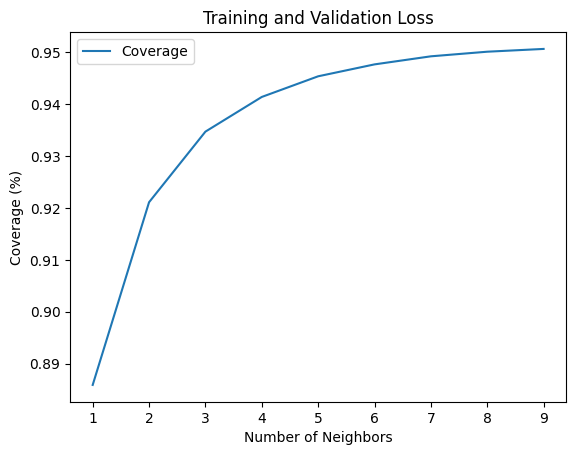

In [17]:
from matplotlib.pylab import plt
# Plot and label the training and validation loss values
plt.plot(hyper_params, cov, label='Coverage')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Number of Neighbors')
plt.ylabel('Coverage (%)')



# Display the plot
plt.legend(loc='best')
plt.show()

In [167]:
# Tune j * train_std => maximize score and balance better for coverage

for j in np.arange(0.5,3,0.25):
  neigh = models[3]
  #Prediction
  predictions = y_validation.to_frame(name="y_true") # the "ground truth" column
  mean = neigh.predict(X_validation)
  predictions["pi_lower"] = mean - j * train_std
  predictions["pi_upper"] = mean + j * train_std

  alpha = 0.1 # the competition alpha
  MWIS,coverage = score(predictions["y_true"],predictions["pi_lower"],predictions["pi_upper"],alpha)
  cov.append(coverage)
  print(f"Number of neighbors ", j)
  print(f"The value of      ",round(MWIS,3))
  print("Predictions coverage   ", round(coverage*100,1),"%")

Number of neighbors  0.5
The value of       5358.114
Predictions coverage    41.2 %
Number of neighbors  0.75
The value of       4176.253
Predictions coverage    57.6 %
Number of neighbors  1.0
The value of       3423.263
Predictions coverage    70.6 %
Number of neighbors  1.25
The value of       3000.674
Predictions coverage    80.1 %
Number of neighbors  1.5
The value of       2813.441
Predictions coverage    86.8 %
Number of neighbors  1.75
The value of       2791.456
Predictions coverage    91.3 %
Number of neighbors  2.0
The value of       2873.407
Predictions coverage    94.1 %
Number of neighbors  2.25
The value of       3024.662
Predictions coverage    96.0 %
Number of neighbors  2.5
The value of       3218.447
Predictions coverage    97.1 %
Number of neighbors  2.75
The value of       3438.654
Predictions coverage    97.8 %


In [172]:
knn = models[3]
y_pred = knn.predict(X_test)
test["pi_lower"] = y_pred - 1.8 * train_std
test["pi_upper"] = y_pred + 1.8 * train_std

In [173]:
res = test[["pi_lower","pi_upper"]]

In [174]:
res.to_csv(submission)